In [1]:
from netCDF4 import Dataset
import pandas as pd
import numpy as np
from scipy import interpolate
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.collections import LineCollection
import os
import pickle as pkl
import matplotlib as mpl
import copy
import colorcet as cc
from scipy import interpolate

cwd = os.getcwd()
hwd = os.path.dirname(cwd)
dir_dls = os.path.join(hwd, "DLS-git")
print(dir_dls)
sys.path.append(dir_dls)

from DLScommonTools import *
from unpackConfigurationsMK import *
from LRBv21 import *
from DLS import *


%load_ext autoreload
%autoreload 2

set_matplotlib_defaults()


c:\Users\mikek\OneDrive\Project\DLS\DLS-git


# IO

In [2]:
file_paths = {
    "V10" : os.path.join(hwd, r"STEPv10\drsep0mm\balance_v10.nc"),
     "V10X" : os.path.join(hwd, r"from_sarah\V10Xgluedgrid_balance\balance.nc"),
     "SPR38" : os.path.join(hwd, r"STEP_SPR038\drsep0mm\balance_SPR038.nc")}

designs = file_paths.keys()
sepadd = 2
eqb = dict()

for design in designs:  
    eqb[design] = dict()

    for side in ["iu", "ou"]:
        eqb[design][side] = unpackConfigurationMK(File = file_paths[design], Type = side, sepadd=sepadd, resolution = 100)

# LRB

In [4]:
# results = dict()

#set switches
radios_default = {
    "ionisation": False,  # WIP - do not use. in development
    "upstreamGrid": True, # SET TRUE if including domain above xpoint. if true, source of divertor heat flux comes from radial transport upstream, and Tu is at the midplane. If false, heat flux simply enters at the x point as qi, and Tu is located at the x point. 
    "fluxlim": False,  # WIP - do not use. if true, turns on a flux limiter with coefficient alpha
}

#set general run parameters
constants_default = {
    "gamma_sheath": 7, #sheath transmittion coefficient for virtual target. Choice does not matter if Tt is low
    "Tt": 0.5, # requested virtual target temp for calculating heat flux at detachment front. Aim for low (sub 1eV) Tt
    
    "qpllu0": 1e9, # heat flux density at the x point
    "nu" : 1e20, # Upstream density (if constant)
    "nu0" : 1e20, # Upstream density (if constant)
    "cz0" : 0.02, # Impurity fraction (if constant)
    
    "Lfunc": LfuncKallenbachAr, # impurity cooling function. More are available in AnalyticCoolingCurves.py
    "alpha": 1000, # WIP - do not use. flux limiting alpha. Only matters if fluxlim is true
}

cvar = "density"
design = "V10"
side = "ou"

d = eqb[design][side].copy() # Load in single profile into dictionary "d"
constants = constants_default.copy() # Set settings to default
radios = radios_default.copy() # Set settings to default
SparRange = np.linspace(0, d["S"][d["Xpoint"]-1], 5) # Solve at these parallel positions

if side == "iu":
    constants["qpllu0"] = constants_default["qpllu0"] * 0.1 # Reduce power to 10% for the inner divertor to account for power sharing.

results = LRBv21(constants, radios, d, [0], verbosity = 0, control_variable = cvar)


NameError: name 'eqb' is not defined

# DLS

In [64]:
#set switches
settings_default = {
    "ionisation": False,  # WIP - do not use. in development
    "upstreamGrid": True, # SET TRUE if including domain above xpoint. if true, source of divertor heat flux comes from radial transport upstream, and Tu is at the midplane. If false, heat flux simply enters at the x point as qi, and Tu is located at the x point. 
    "fluxlim": False,  # WIP - do not use. if true, turns on a flux limiter with coefficient alpha
    "alpha": 1000, # WIP - do not use. flux limiting alpha. Only matters if fluxlim is true
    "gamma_sheath": 7, #sheath transmittion coefficient for virtual target. Choice does not matter if Tt is low
    "Tt": 0.5, # requested virtual target temp for calculating heat flux at detachment front. Aim for low (sub 1eV) Tt
    
    "qpllu0": 1e9, # heat flux density at the x point
    "nu0" : 0.5e19, # Upstream density (if constant)
    "cz0" : 0.05, # Impurity fraction (if constant)
    
    "Lfunc": LfuncKallenbachAr, # impurity cooling function. More are available in AnalyticCoolingCurves.py
    "control_variable" : "density", # Density, impurity_frac or power
    "verbosity" : 3,
    "timeout" : 20, # Max iterations
    "tol" : 1e-3, # convergence tolerance
    "diagnose" : True 
}

d = eqb["V10"]["iu"].copy() # Load in single profile into dictionary "d"

# Run test

### Synthetic

c:\Users\mikek\OneDrive\Project\DLS\DLS-git\DLS.py:415: RuntimeWarning: invalid value encountered in double_scalars
  return [dqoverBds,dtds]
c:\Apps\anaconda3\lib\site-packages\scipy\integrate\odepack.py:247: ODEintWarning: Excess accuracy requested (tolerances too small). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


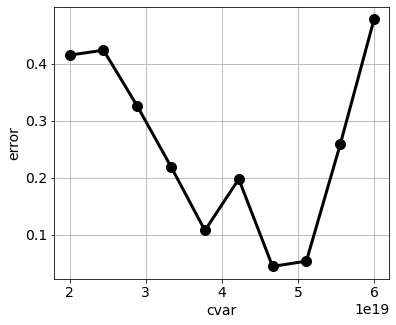

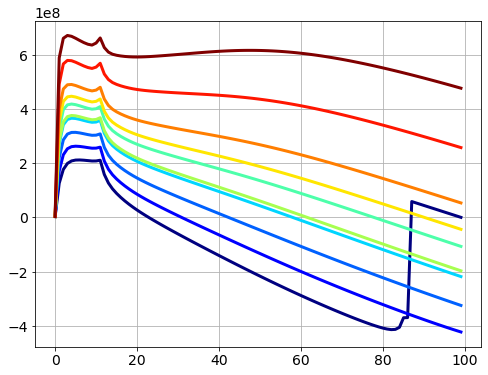

In [181]:
dls = DLS(settings_default, d, 0)
dls.initialize()

nuscan = np.linspace(2e19, 6e19, 10)
# nuscan = [4e19, 5e19]
# nuscan = [4.190285e+19]

for nu in nuscan:
    dls.cvar = nu
    dls.iterate()

dls.plot_error()
dls.plot_log("q")


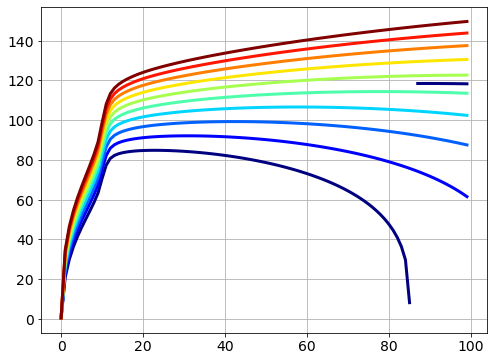

In [164]:
dls.plot_log("T")

In [197]:
dls = DLS(settings_default, d, [0, ])
dls.initialize()
dls.bound_solution()
dls.converge_cvar()

---> Bounding successful. Upper bound: 5.9928102722834694e+19 || Lower bound: 2.9964051361417347e+19
---> Log:
   stage  lbound  ubound          cvar    error1        qpllu1 negative_q
1  bound     0.0     0.0  5.992810e+19  0.507028  5.070280e+08      False
2  bound     0.0     0.0  2.996405e+19 -0.300060 -3.000599e+08       True
---> Solution converged.
---> Log:
      stage        lbound        ubound          cvar    error1        qpllu1  \
1     bound  0.000000e+00  0.000000e+00  5.992810e+19  0.507028  5.070280e+08   
2     bound  0.000000e+00  0.000000e+00  2.996405e+19 -0.300060 -3.000599e+08   
3  Converge  2.996405e+19  5.992810e+19  4.494608e+19  0.081549  8.154946e+07   
4  Converge  2.996405e+19  4.494608e+19  3.745506e+19 -0.115449 -1.154493e+08   
5  Converge  3.745506e+19  4.494608e+19  4.120057e+19 -0.018375 -1.837468e+07   
6  Converge  4.120057e+19  4.494608e+19  4.307332e+19  0.031242  3.124165e+07   
7  Converge  4.120057e+19  4.307332e+19  4.213695e+19  0.006346  

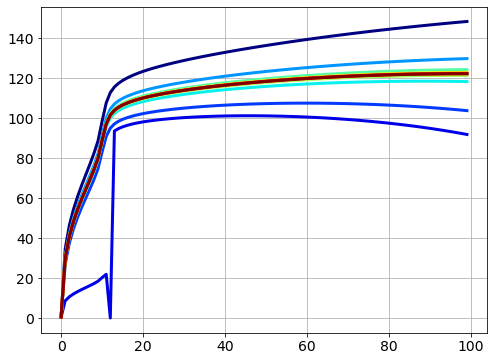

In [186]:
dls.plot_log("T")

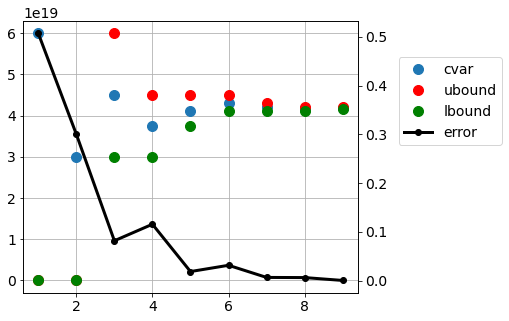

In [170]:
dls.plot_convergence()

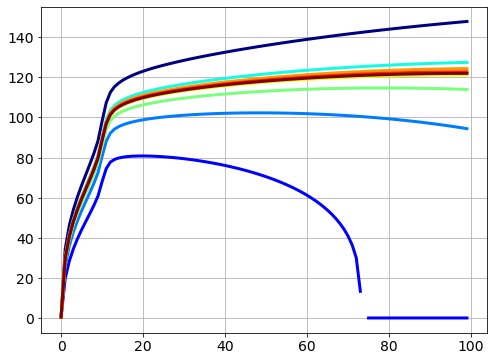

In [189]:
dls.plot_log("T")

## Isolate LRB lengfunc

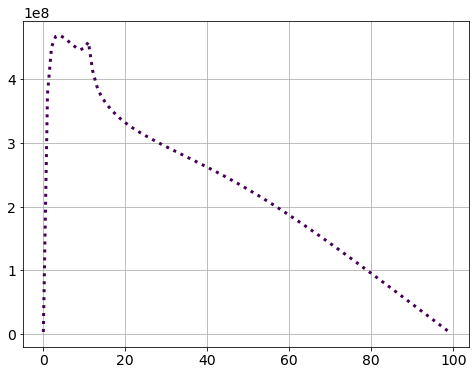

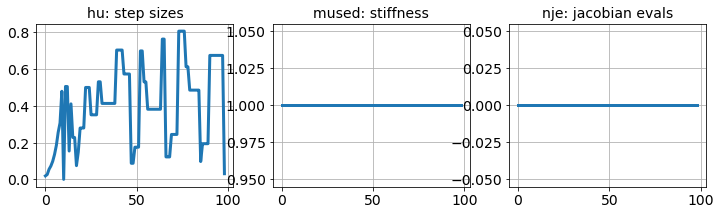

In [71]:
from LRBv21 import *



kappa0 = 2500 # Electron conductivity
mi = 3*10**(-27) # Ion mass
echarge = 1.60*10**(-19) # Electron charge

radios = settings_default.copy()

S = d["S"]
s = S[0:]

Btot = d["Btot"]
B = interpolate.interp1d(d["S"], d["Btot"], kind = "cubic")
Xpoint = d["Xpoint"]
Lfunc = settings_default["Lfunc"]
alpha = settings_default["alpha"]

qpllu0 = settings_default["qpllu0"]
cz = settings_default["cz0"]
nu = settings_default["nu0"]

Tt = settings_default["Tt"]
gamma_sheath = settings_default["gamma_sheath"]

qavLguess = ((qpllu0)*(S[Xpoint]-s[0]) + (qpllu0/2)*(s[-1]-S[Xpoint]))/(s[-1]-S[0])
Tu = ((7/2)*qavLguess*(s[-1]-s[0])/kappa0)**(2/7)

qpllt = gamma_sheath/2 * nu * Tu * echarge*np.sqrt(2*Tt*echarge/mi)
# qradial = qpllu0/np.abs(S[-1]-S[Xpoint])
qradial = qpllu0 / np.trapz(Btot[Xpoint:] / Btot[Xpoint], x = S[Xpoint:])


y = [qpllt/B(s[0]),Tt]


flog = dict()

flog["LRB"] = []

# nuscan = np.linspace(5e19)
nuscan = [4.2e19]

# nuscan = [10e19, 10e19, 10e19, 10e19, 10e19]

study1 = DLS(settings_default, d, 0)

fig, ax = plt.subplots()
colors = make_colors(len(nuscan), plt.get_cmap("viridis"))

for i, nu in enumerate(nuscan):

    result = []
    for x in S[0:]:
        result.append(LengFuncLRBdebug(y,x,kappa0,nu,Tu,cz,qpllu0,alpha,radios,S,B,Xpoint,Lfunc,qradial))

    result = np.array(result)
    flog["LRB"].append(result)

    intresult = odeint(LengFunc, y0 = y, t = S, 
    args = (kappa0,nu,Tu,cz,qpllu0,alpha,radios,S,B,Xpoint,Lfunc,qradial),
    full_output = 1)
    diag = intresult[1]
    ax.plot(intresult[0][:,0] * B(S), color = colors[i], ls = ":")
    # study1.initialize()
    # study1.cvar = nu
    # study1.iterate()
    # ax.plot(study1.log_profiles["q"][i], color = colors[i], ls = "--")

    fig, axes = plt.subplots(1,3, figsize=(12,3))
    axes[0].plot(diag["hu"]); axes[0].set_title("hu: step sizes")
    axes[1].plot(diag["mused"]); axes[1].set_title("mused: stiffness")
    axes[2].plot(diag["nje"]); axes[2].set_title("nje: jacobian evals")




Text(0.5, 1.0, 'nje: jacobian evals')

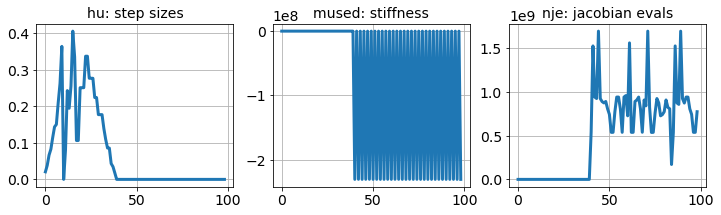

In [45]:
    # 'hu'     vector of step sizes successfully used for each time step
    # 'tcur'   vector with the value of t reached for each time step
    #          (will always be at least as large as the input times)
    # 'tolsf'  vector of tolerance scale factors, greater than 1.0,
    #          computed when a request for too much accuracy was detected
    # 'tsw'    value of t at the time of the last method switch
    #          (given for each time step)
    # 'nst'    cumulative number of time steps
    # 'nfe'    cumulative number of function evaluations for each time step
    # 'nje'    cumulative number of jacobian evaluations for each time step
    # 'nqu'    a vector of method orders for each successful step
    # 'imxer'  index of the component of largest magnitude in the
    #          weighted local error vector (e / ewt) on an error return, -1
    #          otherwise
    # 'lenrw'  the length of the double work array required
    # 'leniw'  the length of integer work array required
    # 'mused'  a vector of method indicators for each successful time step:
    #          1: adams (nonstiff), 2: bdf (stiff)

fig, axes = plt.subplots(1,3, figsize=(12,3))
axes[0].plot(diag["hu"]); axes[0].set_title("hu: step sizes")
axes[1].plot(diag["mused"]); axes[1].set_title("mused: stiffness")
axes[2].plot(diag["nje"]); axes[2].set_title("nje: jacobian evals")

In [42]:
diag["imxer"]

-1

In [61]:
print(f"B test: {B(10)} | {study1.Btot_interp(10)}")
print(f"Bx: {B(Xpoint)} | {study1.Btot_interp(study1.Xpoint)}")
print(f"Sx: {S[Xpoint]} | {study1.Sx}")
print(f"Xpoint: {Xpoint} | {study1.Xpoint}")
print(f'qpllu0: {qpllu0} | {study1.settings["qpllu0"]}')
print(f'cz: {cz} | {study1.cz}')
print(f'nu: {nu} | {study1.nu}')
print(f'Tt: {Tt} | {study1.settings["Tt"]}')
print(f'gamma_sheath: {gamma_sheath} | {study1.settings["gamma_sheath"]}')
print(f'Tu: {Tu} | {study1.Tu}')
print(f'qpllt: {qpllt} | {study1.qpllt0}')
print(f'qradial: {qradial} | {study1.qradial}')


B test: 3.599247194484541 | 3.6053595700681065
Bx: 3.577738290326328 | 3.580983960412514
Sx: 14.325230429615134 | 14.325230429615134
Xpoint: 11 | 11
qpllu0: 1000000000.0 | 1000000000.0
cz: 0.05 | 0.05
nu: 5e+19 | 5e+19
Tt: 0.5 | 0.5
gamma_sheath: 7 | 7
Tu: 151.39531236735837 | 135.78488434775932
qpllt: 3095778.100208007 | 3095778.100208007
qradial: 22287626.87741155 | 22287626.87741155


In [15]:
from DLS import *
dqoverBds["DLS"] = []
dtds["DLS"] = []
dqds["DLS"] = []

study1 = DLS(settings_default, d, 0)

for x in S[0:]:
    [a,b,c] = study1.LengFunc(y,x)

    dqoverBds["DLS"].append(a)
    dtds["DLS"].append(b)
    dqds["DLS"].append(c)

resultDLS = odeint(LengFunc2, y0 = y, t = study1.s, args=(
            study1.kappa0, study1.nu, study1.Tu, study1.cz, study1.S, study1.Btot_interp,
            study1.Xpoint, study1.qradial, study1.settings))

c:\Apps\Anaconda3\envs\py38\lib\site-packages\scipy\integrate\odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


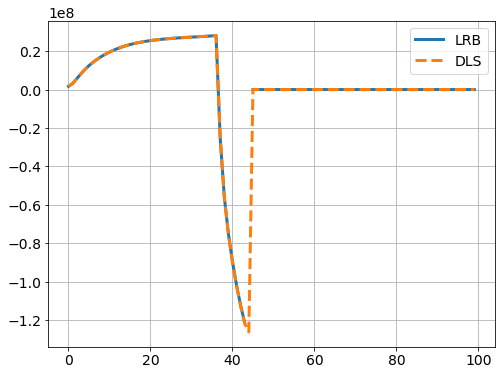

In [16]:
fig, ax = plt.subplots()

ax.plot(resultLRB[:,0], label = "LRB")
ax.plot(resultDLS[:,0], label = "DLS", ls = "--")
ax.legend()

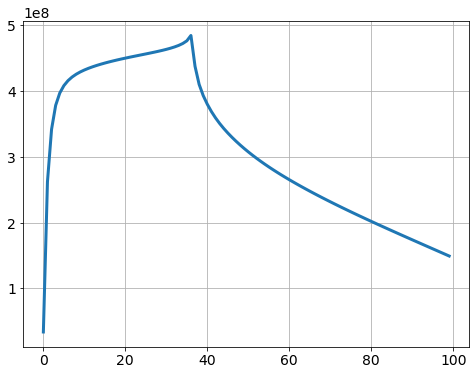

In [143]:
plt.plot(result[:,0])

B test: 2.9914418119665336 | 2.99106262176276
Xpoint: 36 | 36
qpllu0: 1000000000.0 | 1000000000.0
cz: 0.05 | 0.05
nu: 5e+18 | 5e+18
Tt: 0.5 | 0.5
gamma_sheath: 7 | 7
Tu: 148.67614189172338 | 148.67614189172338
qpllt: 3040175.6626055995 | 3040175.6626055995
qradial: 52645653.54178719 | 52645653.54178719


ValueError: x and y must have same first dimension, but have shapes (100,) and (0,)

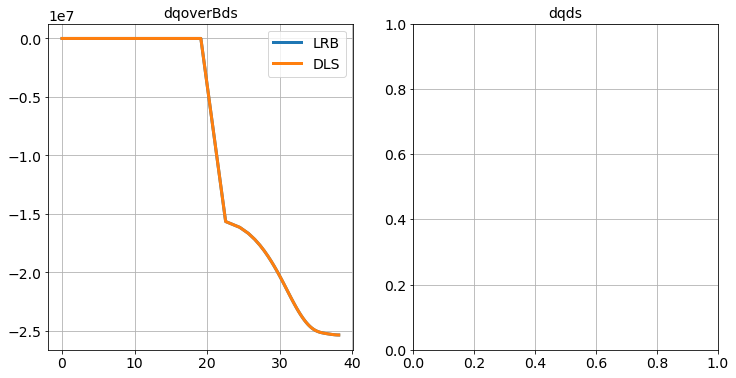

In [205]:
fig, axes = plt.subplots(1,2, figsize=(12,6))

ax = axes[0]; ax.set_title("dqoverBds")
ax.plot(S, dqoverBds["LRB"], label = "LRB")
ax.plot(S, dqoverBds["DLS"], label = "DLS")
ax.legend()

ax = axes[1]; ax.set_title("dqds")
ax.plot(S, dqds["LRB"], label = "LRB")
ax.plot(S, dqds["DLS"], label = "DLS")

In [199]:
from DLS import *

In [34]:
settings = settings_default.copy()
settings["timeout"] = 5
study2 = DLS(settings, d, 0)
study2.initialize()
study2.bound_solution()
# study2.converge()

c:\Users\Mike\OneDrive\Project\DLS\DLS-git\DLS.py:377: RuntimeWarning: invalid value encountered in double_scalars
  dtds = qoverB*fieldValue/(kappa0*T**(5/2))
c:\Users\Mike\OneDrive\Project\DLS\DLS-git\DLS.py:121: RuntimeWarning: invalid value encountered in double_scalars
  self.R = [((self.settings["nu0"]**2 * self.Tu**2) / x**2) * self.cz * self.settings["Lfunc"](x) for x in self.T]


error1: 0.000E+00 | nu: 5.000E+18 | Tu: 0.0 | cvar: 5.00E+18

c:\Apps\Anaconda3\envs\py38\lib\site-packages\scipy\integrate\odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


error1: 0.000E+00 | nu: 5.000E+18 | Tu: 0.0 | cvar: 5.00E+18error1: 0.000E+00 | nu: 5.000E+18 | Tu: 0.0 | cvar: 5.00E+18error1: 0.000E+00 | nu: 5.000E+18 | Tu: 0.0 | cvar: 5.00E+18error1: 0.000E+00 | nu: 5.000E+18 | Tu: 0.0 | cvar: 5.00E+18

c:\Apps\Anaconda3\envs\py38\lib\site-packages\scipy\integrate\odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
c:\Users\Mike\OneDrive\Project\DLS\DLS-git\DLS.py:121: RuntimeWarning: invalid value encountered in double_scalars
  self.R = [((self.settings["nu0"]**2 * self.Tu**2) / x**2) * self.cz * self.settings["Lfunc"](x) for x in self.T]


error1: -3.955E-02 | nu: 1.000E+19 | Tu: 0.0 | cvar: 1.00E+19error1: -3.955E-02 | nu: 1.000E+19 | Tu: 0.0 | cvar: 1.00E+19error1: -3.955E-02 | nu: 1.000E+19 | Tu: 0.0 | cvar: 1.00E+19error1: -3.955E-02 | nu: 1.000E+19 | Tu: 0.0 | cvar: 1.00E+19error1: -3.955E-02 | nu: 1.000E+19 | Tu: 0.0 | cvar: 1.00E+19

c:\Apps\Anaconda3\envs\py38\lib\site-packages\scipy\integrate\odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
c:\Users\Mike\OneDrive\Project\DLS\DLS-git\DLS.py:121: RuntimeWarning: invalid value encountered in double_scalars
  self.R = [((self.settings["nu0"]**2 * self.Tu**2) / x**2) * self.cz * self.settings["Lfunc"](x) for x in self.T]


error1: -3.955E-02 | nu: 2.000E+19 | Tu: 0.0 | cvar: 2.00E+19error1: -3.955E-02 | nu: 2.000E+19 | Tu: 0.0 | cvar: 2.00E+19error1: -3.955E-02 | nu: 2.000E+19 | Tu: 0.0 | cvar: 2.00E+19error1: -3.955E-02 | nu: 2.000E+19 | Tu: 0.0 | cvar: 2.00E+19error1: -3.955E-02 | nu: 2.000E+19 | Tu: 0.0 | cvar: 2.00E+19

c:\Apps\Anaconda3\envs\py38\lib\site-packages\scipy\integrate\odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
c:\Users\Mike\OneDrive\Project\DLS\DLS-git\DLS.py:121: RuntimeWarning: invalid value encountered in double_scalars
  self.R = [((self.settings["nu0"]**2 * self.Tu**2) / x**2) * self.cz * self.settings["Lfunc"](x) for x in self.T]


error1: -3.955E-02 | nu: 4.000E+19 | Tu: 0.0 | cvar: 4.00E+19error1: -3.955E-02 | nu: 4.000E+19 | Tu: 0.0 | cvar: 4.00E+19error1: -3.955E-02 | nu: 4.000E+19 | Tu: 0.0 | cvar: 4.00E+19error1: -3.955E-02 | nu: 4.000E+19 | Tu: 0.0 | cvar: 4.00E+19error1: -3.955E-02 | nu: 4.000E+19 | Tu: 0.0 | cvar: 4.00E+19

c:\Apps\Anaconda3\envs\py38\lib\site-packages\scipy\integrate\odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
c:\Users\Mike\OneDrive\Project\DLS\DLS-git\DLS.py:121: RuntimeWarning: invalid value encountered in double_scalars
  self.R = [((self.settings["nu0"]**2 * self.Tu**2) / x**2) * self.cz * self.settings["Lfunc"](x) for x in self.T]


error1: -3.955E-02 | nu: 8.000E+19 | Tu: 0.0 | cvar: 8.00E+19error1: -3.955E-02 | nu: 8.000E+19 | Tu: 0.0 | cvar: 8.00E+19error1: -3.955E-02 | nu: 8.000E+19 | Tu: 0.0 | cvar: 8.00E+19error1: -3.955E-02 | nu: 8.000E+19 | Tu: 0.0 | cvar: 8.00E+19error1: -3.955E-02 | nu: 8.000E+19 | Tu: 0.0 | cvar: 8.00E+19

c:\Apps\Anaconda3\envs\py38\lib\site-packages\scipy\integrate\odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
c:\Users\Mike\OneDrive\Project\DLS\DLS-git\DLS.py:121: RuntimeWarning: invalid value encountered in double_scalars
  self.R = [((self.settings["nu0"]**2 * self.Tu**2) / x**2) * self.cz * self.settings["Lfunc"](x) for x in self.T]


error1: -3.955E-02 | nu: 1.600E+20 | Tu: 0.0 | cvar: 1.60E+20error1: -3.955E-02 | nu: 1.600E+20 | Tu: 0.0 | cvar: 1.60E+20error1: -3.955E-02 | nu: 1.600E+20 | Tu: 0.0 | cvar: 1.60E+20error1: -3.955E-02 | nu: 1.600E+20 | Tu: 0.0 | cvar: 1.60E+20error1: -3.955E-02 | nu: 1.600E+20 | Tu: 0.0 | cvar: 1.60E+20---X Cannot proceed. Bounding timeout.
---> Log:
   stage  lbound  ubound          cvar    error1        qpllu1 ode_error
1  bound     0.0     0.0  5.000000e+18 -0.039548 -3.954787e+07      True
2  bound     0.0     0.0  1.000000e+19 -0.039548 -3.954787e+07      True
3  bound     0.0     0.0  2.000000e+19 -0.039548 -3.954787e+07      True
4  bound     0.0     0.0  4.000000e+19 -0.039548 -3.954787e+07      True
5  bound     0.0     0.0  8.000000e+19 -0.039548 -3.954787e+07      True
6  bound     0.0     0.0  1.600000e+20 -0.176492 -1.764917e+08      True


SystemExit: 

c:\Apps\Anaconda3\envs\py38\lib\site-packages\IPython\core\interactiveshell.py:3406: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


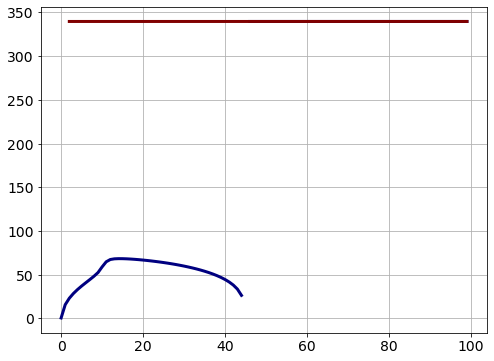

In [30]:
study2.plot_log("T")

In [216]:
settings = settings_default.copy()
settings["timeout"] = 5
study1 = DLS(settings, d, 0)
study1.bound_solution()
study1.converge()

c:\Apps\Anaconda3\envs\py38\lib\site-packages\scipy\integrate\odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


---> Bounding successful. Upper bound: 1.6e+20 || Lower bound: 8e+19
---> Log:
   stage  lbound  ubound          cvar    error1        qpllu1 ode_error
1  bound     0.0     0.0  5.000000e+18 -0.348709 -3.487095e+08      True
2  bound     0.0     0.0  1.000000e+19 -0.474741 -4.747414e+08      True
3  bound     0.0     0.0  2.000000e+19 -0.595109 -5.951091e+08      True
4  bound     0.0     0.0  4.000000e+19 -0.551613 -5.516126e+08      True
5  bound     0.0     0.0  8.000000e+19 -0.078782 -7.878226e+07      True
6  bound     0.0     0.0  1.600000e+20  2.361996  2.361996e+09     False
---X Cannot proceed. Convergence timeout.
---> Log:
       stage        lbound        ubound          cvar    error1  \
1      bound  0.000000e+00  0.000000e+00  5.000000e+18 -0.348709   
2      bound  0.000000e+00  0.000000e+00  1.000000e+19 -0.474741   
3      bound  0.000000e+00  0.000000e+00  2.000000e+19 -0.595109   
4      bound  0.000000e+00  0.000000e+00  4.000000e+19 -0.551613   
5      bound  0.00

SystemExit: 

c:\Apps\Anaconda3\envs\py38\lib\site-packages\IPython\core\interactiveshell.py:3406: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


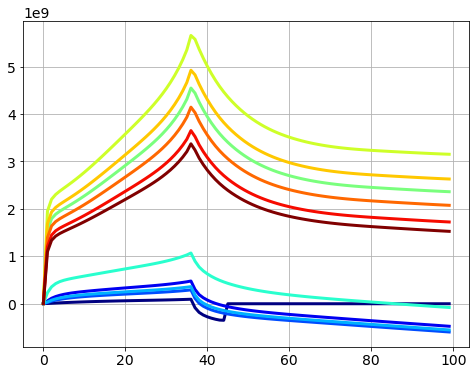

In [218]:
study1.plot_log("q")

# Parameter space scan

c:\Apps\Anaconda3\envs\py38\lib\site-packages\scipy\integrate\odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
c:\Users\Mike\OneDrive\Project\DLS\DLS-git\DLS.py:115: RuntimeWarning: divide by zero encountered in double_scalars
  self.Tucalc = self.Tu.copy()
c:\Users\Mike\OneDrive\Project\DLS\DLS-git\DLS.py:115: RuntimeWarning: invalid value encountered in double_scalars
  self.Tucalc = self.Tu.copy()
c:\Users\Mike\OneDrive\Project\DLS\DLS-git\DLS.py:115: RuntimeWarning: overflow encountered in double_scalars
  self.Tucalc = self.Tu.copy()
c:\Apps\Anaconda3\envs\py38\lib\site-packages\scipy\integrate\odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
c:\Users\Mike\OneDrive\Project\DLS\DLS-git\DLS.py:115: Runtime

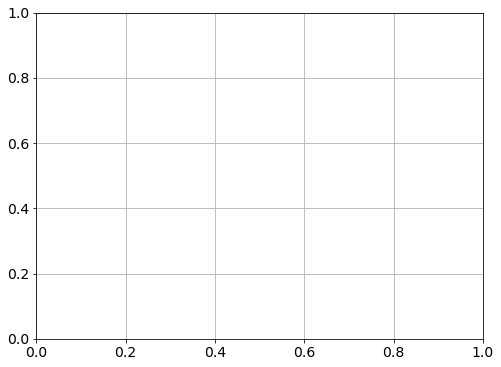

In [197]:
BxBt_scale = 1
Lc_scale = 1
design = "V10"
side = "ou"


nuscan = np.linspace(1e19, 1e20, 10)
study1 = DLS(settings_default, d, 0)
# study1.cvar = 0.1e+20
# study1.iterate()

study1.plot_log("q")

# study1.iterate()
# print(study1.qradial)

# Qradial correct 64632643.421390474
# y0 is [31231965.77943709, 0.5]
# LRB   [33580815.89239981, 0.5]

# qpllt is 59547285.21816886
# LRB is   60803513.25211199


for nu in nuscan:
    study1.cvar = nu
    study1.iterate()

#     print(f"{nu}..", end="")

In [196]:
study1.log_table

,stage,lbound,ubound,cvar,error1,qpllu1,ode_error
1,Initialise,0.0,0.0,1.000000e+19,-5.216805e-01,-5.216805e+08,True
2,Initialise,0.0,0.0,2.000000e+19,-9.734197e-02,-9.734197e+07,True
3,Initialise,0.0,0.0,3.000000e+19,-9.734197e-02,-9.734197e+07,True
4,Initialise,0.0,0.0,4.000000e+19,-9.734197e-02,-9.734197e+07,True
5,Initialise,0.0,0.0,5.000000e+19,-9.734197e-02,-9.734197e+07,True
6,Initialise,0.0,0.0,6.000000e+19,-9.734197e-02,-9.734197e+07,True
7,Initialise,0.0,0.0,7.000000e+19,-9.734197e-02,-9.734197e+07,True
8,Initialise,0.0,0.0,8.000000e+19,-9.734197e-02,-9.734197e+07,True
9,Initialise,0.0,0.0,9.000000e+19,-9.734197e-02,-9.734197e+07,True
10,Initialise,0.0,0.0,1.000000e+20,1.653638e-320,1.653844e-311,False


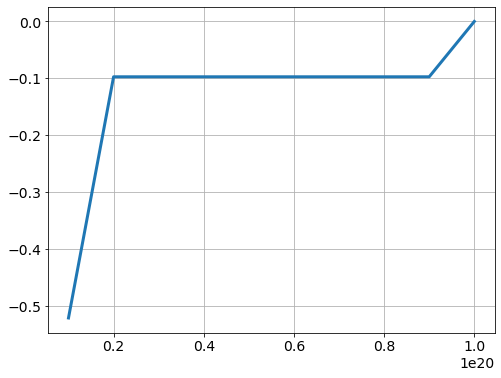

In [194]:
plt.plot(study1.log_table["cvar"], study1.log_table["error1"])

## T profiles

[ 0.5        20.44108529 27.83015343 33.01315262 37.07821866]
[ 0.5        16.30740683 21.68387436 25.6293335  28.82231768]
[ 0.5        14.51384668 18.43405357 21.32106078 23.68653671]
[ 0.5        13.94727583 17.23148675 19.5613379  21.43653864]
[ 0.5        13.79495072 16.88506689 19.02649735 20.72253876]


(0.0, 200.76356302904503)

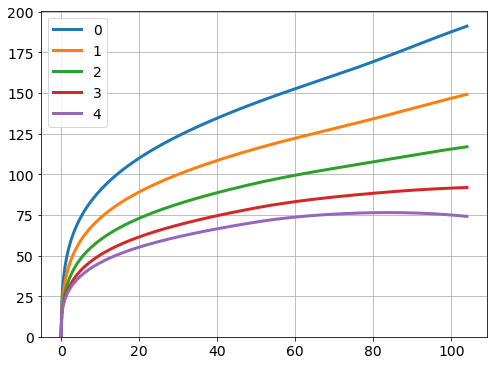

In [77]:
fig, ax = plt.subplots()

for i in range(5):
    ax.plot(out["Sprofiles"][0],out["logs"][0]["Tprofiles"][i], label = i)
    print(out["logs"][0]["Tprofiles"][i][:5])
ax.legend()
ax.set_ylim(0, ax.get_ylim()[1])

## Q profiles

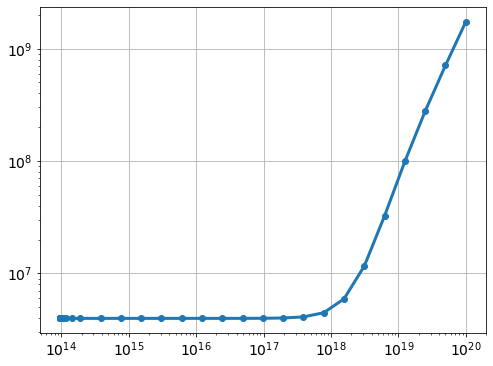

In [74]:
fig, ax = plt.subplots()
ax.plot(out["logs"][0]["cvar"], out["logs"][0]["qpllu1"], marker = "o")
ax.set_yscale("log")
ax.set_xscale("log")

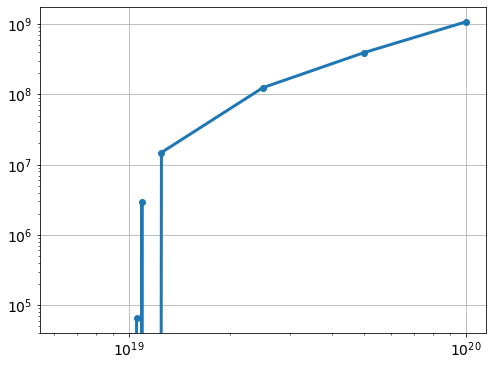

In [76]:
fig, ax = plt.subplots()
ax.plot(out["logs"][0]["cvar"], out["logs"][0]["qpllu1"], marker = "o")
ax.set_yscale("log")
ax.set_xscale("log")

Cvar 1e+20 | qpllu1  1729923451.8197176 || [4.17597226e+07 2.68504245e+08 3.70847615e+08 4.27910626e+08
 4.63269543e+08]
Cvar 5e+19 | qpllu1  708874714.8994704 || [4.17597226e+07 1.07916746e+08 1.48676469e+08 1.76173089e+08
 1.96365743e+08]
Cvar 2.5e+19 | qpllu1  277836913.7168165 || [41759722.5537524  59400619.35514384 72350352.08360614 82109674.45187508
 90014539.6302083 ]
Cvar 1.25e+19 | qpllu1  99348240.73844323 || [41759722.5537524  46416823.29368841 50092270.21754821 53047171.74299765
 55569272.61223856]
Cvar 6.25e+18 | qpllu1  32580073.6100585 || [41759722.5537524  43109143.72150129 44226505.35419116 45171441.28167579
 46012510.51594067]
Cvar 3.125e+18 | qpllu1  11640280.994720584 || [41759722.5537524  42278240.84477982 42738502.01879221 43155426.93516661
 43546267.12182095]
Cvar 1.5625e+18 | qpllu1  5937216.751595062 || [41759722.5537524  42070262.4590541  42365101.18344196 42648294.19476566
 42924485.35521271]
Cvar 7.8125e+17 | qpllu1  4475482.427923074 || [41759722.5537524  4

(0.0, 1816218845.7123618)

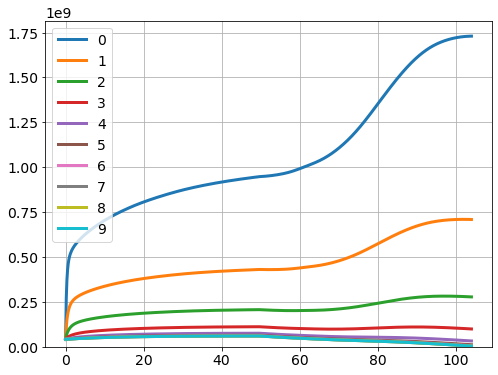

In [69]:
fig, ax = plt.subplots()

for i in range(10):
    ax.plot(out["Sprofiles"][0],out["logs"][0]["Qprofiles"][i], label = i)
    print(f'Cvar {out["logs"][0]["cvar"][i]} | qpllu1  {out["logs"][0]["qpllu1"][i]} || {out["logs"][0]["Qprofiles"][i][:5]}')
ax.legend()
ax.set_ylim(0, ax.get_ylim()[1])

Cvar 1e+20 | qpllu1  1078339104.225997 || [4.17597226e+07 2.67048949e+08 3.66666369e+08 4.20429016e+08
 4.52137082e+08]
Cvar 5e+19 | qpllu1  394833858.69980484 || [4.17597226e+07 1.07232317e+08 1.46886271e+08 1.73016874e+08
 1.91673652e+08]
Cvar 2.5e+19 | qpllu1  124698797.37466183 || [41759722.5537524  58930016.99767609 71294902.89355193 80386301.24763367
 87559065.13280666]
Cvar 1.25e+19 | qpllu1  14873487.002625432 || [41759722.5537524  46001886.76007185 49235006.34063764 51726811.11199662
 53768364.98144566]
Cvar 6.25e+18 | qpllu1  -28403997.85786118 || [41759722.5537524  42708304.53084946 43419893.47503691 43955185.78377235
 44382950.46344054]


(0.0, 1133676259.33019)

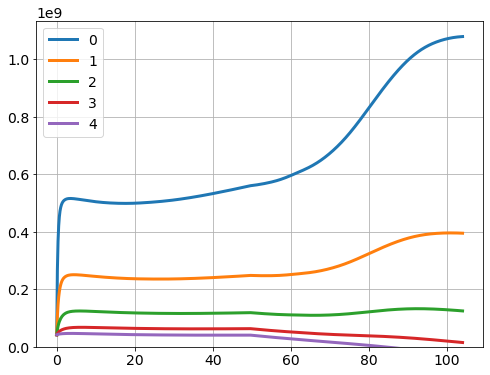

In [66]:
fig, ax = plt.subplots()

for i in range(5):
    ax.plot(out["Sprofiles"][0],out["logs"][0]["Qprofiles"][i], label = i)
    print(f'Cvar {out["logs"][0]["cvar"][i]} | qpllu1  {out["logs"][0]["qpllu1"][i]} || {out["logs"][0]["Qprofiles"][i][:5]}')
ax.legend()
ax.set_ylim(0, ax.get_ylim()[1])